In [14]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import soaplite
import genBasis
import ase
from ase.visualize import view
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as p
from numpy.linalg import norm
from scipy.optimize import fmin
import scipy.optimize as op
import time
%matplotlib inline

In [2]:
# have not tested this configuration yet, keeping this for future testing
atoms = ase.io.read(currentdir + "/Structs/au80.xyz")
atoms.set_cell(15 * np.identity(3))
atoms.set_pbc((1,1,1))
#atoms.wrap()
view(atoms)
atoms.get_cell()

array([[15.,  0.,  0.],
       [ 0., 15.,  0.],
       [ 0.,  0., 15.]])

In [3]:
# this is the configuration that i am testing on
atoms = ase.io.read(currentdir + "/glass_cube_CuZr.cfg")
view(atoms)
print(atoms.get_cell())
print(np.shape(atoms.get_chemical_symbols()))

[[10.  0.  0.]
 [ 0. 10.  0.]
 [ 0.  0. 70.]]
(207,)


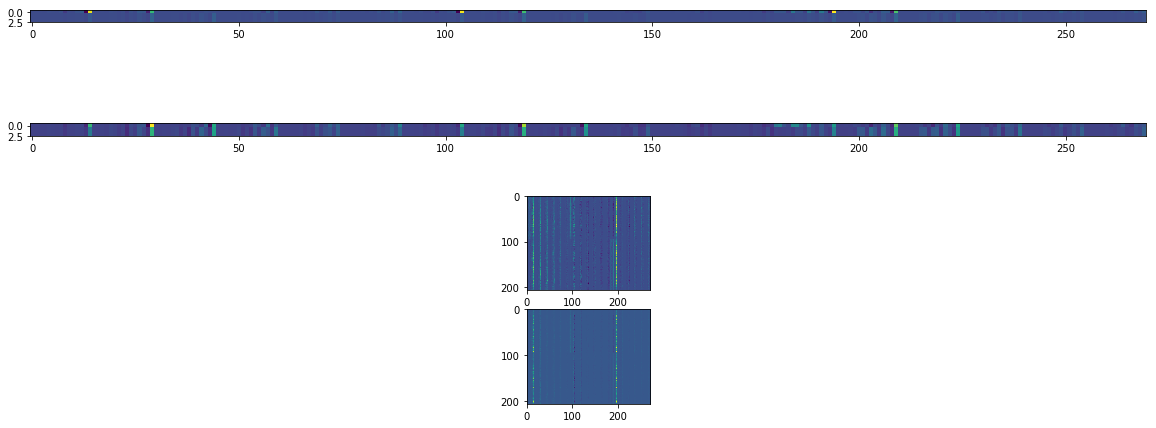

In [4]:
# this initializes basis functions for soap and tests some outputs
myAlphas, myBetas = genBasis.getBasisFunc(10.0, 5) # input: (rCut, NradBas)
#Hpos = [[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,9.0],[10.0,11.0,12.0]]
#Hpos = [[1.0,1.0,1.0],[1.0,1.0,1.0],[1.0,1.0,1.0],[1.0,1.0,1.0]]
Hpos = atoms[-1].position
rCut = 10.0
NradBas = 5
Lmax = 5
x = soaplite.get_periodic_soap_locals(atoms, Hpos, myAlphas, myBetas, rCut, NradBas, Lmax)
xp = soaplite.get_soap_locals(atoms, Hpos, myAlphas, myBetas, rCut, NradBas, Lmax)
y = soaplite.get_soap_structure(atoms, myAlphas, myBetas, rCut, NradBas, Lmax)
yp = soaplite.get_periodic_soap_structure(atoms, myAlphas, myBetas, rCut, NradBas, Lmax)

fig,(ax1,ax2,ax3,ax4)=p.subplots(4,1,figsize=(20,8))
ax1.imshow(x)
ax2.imshow(xp)
ax3.imshow(y)
ax4.imshow(yp)

In [5]:
def randPos(atoms_in): # function to randomize atom positions. New positions will be inside Unit cell
    atoms = atoms_in.copy()
    pos = atoms.get_positions()
    shape = pos.shape
    ran_pos = np.random.random_sample(shape)
    cell = atoms.get_cell()
    for i in np.arange(shape[0]):
        pos[i] = np.matmul(cell,ran_pos[i])
    atoms.set_positions(pos)
    return atoms

In [6]:
def limit_pos(atoms): # funtion to delete atoms outside of unit cell, only works with orthorhombic cells (for now)
    cell = atoms.get_cell()
    pos = atoms.get_positions()
    N = np.shape(pos)[0]
    x_max = cell[0,0]
    y_max = cell[1,1]
    z_max = cell[2,2]
    i = 0
    while(i < N-1):
        pos = atoms.get_positions()
        N = np.shape(pos)[0]
        if pos[i,0] > cell[0,0] or pos[i,1] > cell[1,1] or pos[i,2] > cell[2,2]:
            atoms.pop(i)
        else:
            i = i + 1
    return atoms

In [7]:
# shows how/if the limiting to unitcell works 
atoms_small = atoms.copy()
atoms_small.set_cell(10 * np.identity(3))
atoms_small = limit_pos(atoms_small).copy()
view(atoms_small)
view(atoms)

35.86766265961456
42.09632506502863


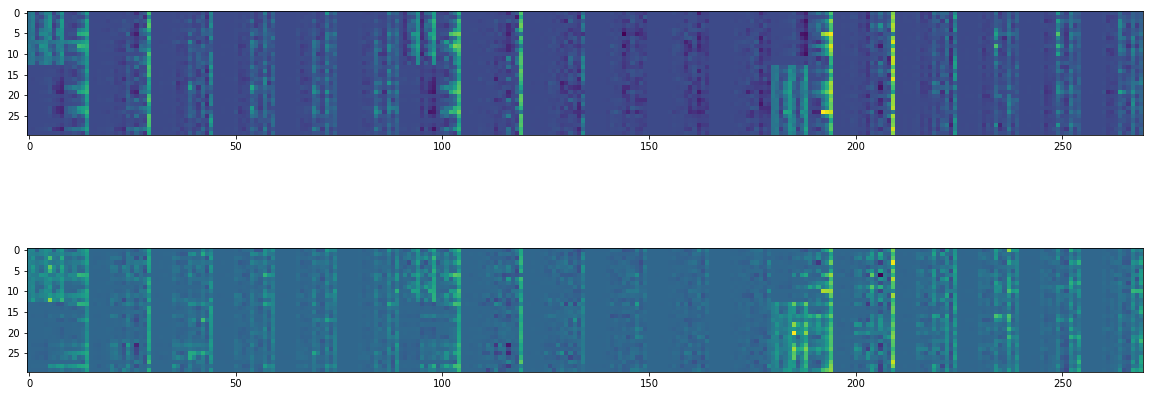

In [8]:
# calculates and shows first matrices for normal structure and randomized
atoms_ran = randPos(atoms_small).copy()
#view(atoms_ran)
y = soaplite.get_soap_structure(atoms_small, myAlphas, myBetas, rCut, NradBas, Lmax)
y_ran = soaplite.get_soap_structure(atoms_ran, myAlphas, myBetas, rCut, NradBas, Lmax)

fig,(ax1,ax2)=p.subplots(2,1,figsize=(20,8))
ax1.imshow(y)
ax2.imshow(y_ran)
print(norm(y))
print(norm(y_ran))

In [9]:
def soap_norm(pos, atoms_obj, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5):
    # calculates the matrix-norm of the SOAP-matrix from a flattened positions-array and an atoms object.
    # SOAP basisfunctions have to be calculated beforehand and parsed to the function, rCut, NradBas and Lmax may also be parsed
    atoms = atoms_obj.copy()
    # i dont know if copying is always necessary, but it seems change the object unexpectedly so im going the safe route 
    pos_ini = atoms.get_positions()
    pos = np.reshape(pos, pos_ini.shape)
    atoms.set_positions(pos)
    #mat = soaplite.get_periodic_soap_structure(atoms, myAlphas, myBetas, rCut, NradBas, Lmax)
    mat = soaplite.get_soap_structure(atoms, myAlphas, myBetas, rCut, NradBas, Lmax)
    #print(norm(mat)) # can be used to show progress, but slows down function calls somewhat
    return norm(mat)

In [10]:
# this starts the minimization.
x0 = randPos(atoms_small).get_positions()
t0 = time.time()
print(soap_norm(x0, atoms_small, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5))
[xopt, fopt, ite, funcalls, warnflags, allvec] = fmin(soap_norm, x0, args=(atoms_small, myAlphas, myBetas, rCut, NradBas, Lmax), disp=True, retall=True, maxiter=50000, full_output=True)
# sometimes it does not converge, depends on starting values. new random ones are put in everytime, so restarting helps 
t1 = time.time()
dt = t1 - t0
#print(soap_norm(xopt, atoms, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5))
print('Time passed: %f s' %dt)


44.070182741797225
Time passed: 33.812781 s


In [11]:
def show_res(atoms_obj, pos):
    # shows the result of the minimization in form of the view from ase
    atoms = atoms_obj.copy()
    pos_ini = atoms.get_positions()
    pos = np.reshape(pos, pos_ini.shape)
    atoms.set_positions(pos)
    view(atoms)
    

In [12]:
show_res(atoms_small, xopt)
# clearly restraints need to be put in place

In [23]:
x0 = randPos(atoms_small).get_positions()
t0 = time.time()
print(soap_norm(x0, atoms_small, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5))
op_options = {'maxiter': 50000, 'disp': True}
res_obj = op.minimize(soap_norm, x0, args=(atoms_small, myAlphas, myBetas, rCut, NradBas, Lmax),  options=op_options)
# sometimes it does not converge, depends on starting values. new random ones are put in everytime, so restarting helps 
t1 = time.time()
dt = t1 - t0
#print(soap_norm(xopt, atoms, myAlphas, myBetas, rCut=10.0, NradBas=5, Lmax=5))
print('Time passed: %f s' %dt)

42.85197348177078
Optimization terminated successfully.
         Current function value: 8.519368
         Iterations: 67
         Function evaluations: 6348
         Gradient evaluations: 69
Time passed: 4.957376 s


In [24]:
xopt = res_obj.x

In [25]:
show_res(atoms_small, xopt)